<a href="https://colab.research.google.com/github/mycoderisyad/mygooglecollab/blob/main/M_RISYAD_RAFLAN_20240200004_UAS_STATISTIKA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

library

In [ ]:
import pandas as pd
import numpy as np
from scipy.stats import shapiro
import statsmodels.api as sm
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [ ]:
df = pd.read_excel('DATA_INDONESIA.xlsx')

Menampilkan header/variable di dalam file

In [ ]:
print(df.columns)

Index(['W_FSTUWT', 'W_FSTURWT1', 'W_FSTURWT2', 'W_FSTURWT3', 'W_FSTURWT4',
       'W_FSTURWT5', 'W_FSTURWT6', 'W_FSTURWT7', 'W_FSTURWT8', 'W_FSTURWT9',
       'W_FSTURWT10', 'W_FSTURWT11', 'W_FSTURWT12', 'W_FSTURWT13',
       'W_FSTURWT14', 'W_FSTURWT15', 'W_FSTURWT16', 'W_FSTURWT17',
       'W_FSTURWT18', 'W_FSTURWT19', 'W_FSTURWT20', 'W_FSTURWT21',
       'W_FSTURWT22', 'W_FSTURWT23', 'W_FSTURWT24', 'W_FSTURWT25',
       'W_FSTURWT26', 'W_FSTURWT27', 'W_FSTURWT28', 'W_FSTURWT29',
       'W_FSTURWT30', 'W_FSTURWT31', 'W_FSTURWT32', 'W_FSTURWT33',
       'W_FSTURWT34', 'W_FSTURWT35', 'W_FSTURWT36', 'W_FSTURWT37',
       'W_FSTURWT38', 'W_FSTURWT39', 'W_FSTURWT40', 'W_FSTURWT41',
       'W_FSTURWT42', 'W_FSTURWT43', 'W_FSTURWT44', 'W_FSTURWT45',
       'W_FSTURWT46', 'W_FSTURWT47', 'W_FSTURWT48', 'W_FSTURWT49',
       'W_FSTURWT50', 'W_FSTURWT51', 'W_FSTURWT52', 'W_FSTURWT53',
       'W_FSTURWT54', 'W_FSTURWT55', 'W_FSTURWT56', 'W_FSTURWT57',
       'W_FSTURWT58', 'W_FSTURWT59', 'W_FSTU

CLEANING DATA

In [ ]:
# Filter nilai valid pendidikan ortu
df = df[df['ST005Q01JA'].isin([1,2,3,4,5])]
df = df[df['ST007Q01JA'].isin([1,2,3,4,5])]

# Filter ESCS
df = df[pd.to_numeric(df['ESCS'], errors='coerce').notnull()]

# Pastikan semua PV sains numerik
for i in range(1, 11):
    df[f'PV{i}SCIE'] = pd.to_numeric(df[f'PV{i}SCIE'], errors='coerce')

# Pastikan weight numerik (main & replicate)
df['W_FSTUWT'] = pd.to_numeric(df['W_FSTUWT'], errors='coerce')
for i in range(1,81):
    df[f'W_FSTURWT{i}'] = pd.to_numeric(df[f'W_FSTURWT{i}'], errors='coerce')

# Drop baris yang masih ada NA di variabel penting
df_clean = df[
    ['W_FSTUWT'] +
    [f'W_FSTURWT{i}' for i in range(1,81)] +
    [f'PV{i}SCIE' for i in range(1,11)] +
    ['ESCS', 'ST005Q01JA', 'ST007Q01JA']
].dropna()

print("Jumlah data setelah cleaning:", df_clean.shape)
print(df_clean.head())


Jumlah data setelah cleaning: (13062, 94)
    W_FSTUWT  W_FSTURWT1  W_FSTURWT2  W_FSTURWT3  W_FSTURWT4  W_FSTURWT5  \
0   45.23796    67.85694    22.61898    67.85694    22.61898    67.85694   
1    6.35773     3.17886     9.53659     3.17886     9.53659     3.17886   
2   72.13088    34.45015   112.31670   112.31670    34.45015    34.45015   
5  558.76300   279.38150   279.38150   838.14440   279.38150   279.38150   
6  638.23670   311.11810   311.11810   311.11810   977.53870   986.68530   

   W_FSTURWT6  W_FSTURWT7  W_FSTURWT8  W_FSTURWT9  ...  PV4SCIE  PV5SCIE  \
0    67.85694    67.85694    67.85694    22.61898  ...  426.561  491.898   
1     3.17886     3.17886     3.17886     9.53659  ...  371.197  365.165   
2   112.31670   112.31670   112.31670   112.31670  ...  329.184  379.009   
5   279.38150   279.38150   838.14440   838.14440  ...  442.084  434.072   
6   308.39850   977.53870   986.68530   308.39850  ...  315.179  315.928   

   PV6SCIE  PV7SCIE  PV8SCIE  PV9SCIE  PV10S

In [ ]:
df_clean.to_excel('data_clean.xlsx', index=False)

In [ ]:
def weighted_mean(y, weight):
    return np.sum(y * weight) / np.sum(weight)

In [ ]:
means = []
for i in range(1, 11):
    mean_pv = weighted_mean(df_clean[f'PV{i}SCIE'], df_clean['W_FSTUWT'])
    means.append(mean_pv)

mean_sains = np.mean(means)
print("Weighted Mean Skor Sains (10 PV):", mean_sains)
rep_means = []
for j in range(1, 81):  # 80 replicate weights
    rep_mean_pv = []
    for i in range(1, 11):  # 10 PV
        rep_mean = weighted_mean(df_clean[f'PV{i}SCIE'], df_clean[f'W_FSTURWT{j}'])
        rep_mean_pv.append(rep_mean)
    rep_means.append(np.mean(rep_mean_pv))
rep_means = np.array(rep_means)
# BRR (balanced repeated replication) formula dari Technical Report OECD
se = np.sqrt(np.sum((rep_means - mean_sains)**2) / 80)
print("Standard Error (BRR, 80 replicate weights):", se)
lower = mean_sains - 1.96*se
upper = mean_sains + 1.96*se
print(f"95% CI: {lower:.2f} – {upper:.2f}")

Weighted Mean Skor Sains (10 PV): 383.5442133819927
Standard Error (BRR, 80 replicate weights): 1.1867966507455676
95% CI: 381.22 – 385.87


Statistik Deskriptif Variabel X (ESCS & Pendidikan Ortu)

In [ ]:
# Weighted mean ESCS
mean_escs = weighted_mean(df_clean['ESCS'], df_clean['W_FSTUWT'])

# Replicate means ESCS
rep_means_escs = []
for j in range(1, 81):
    rep_mean = weighted_mean(df_clean['ESCS'], df_clean[f'W_FSTURWT{j}'])
    rep_means_escs.append(rep_mean)
rep_means_escs = np.array(rep_means_escs)

# SE dan CI ESCS
se_escs = np.sqrt(np.sum((rep_means_escs - mean_escs) ** 2) / 80)
lower_escs = mean_escs - 1.96 * se_escs
upper_escs = mean_escs + 1.96 * se_escs

print(f"Weighted Mean ESCS: {mean_escs:.3f}")
print(f"SE ESCS: {se_escs:.4f}")
print(f"95% CI: {lower_escs:.3f} – {upper_escs:.3f}")

Weighted Mean ESCS: -1.551
SE ESCS: 0.0176
95% CI: -1.585 – -1.516


In [ ]:
# Weighted mean ST005Q01JA (Pendidikan Ibu)
mean_ST005Q01JA = weighted_mean(df_clean['ST005Q01JA'], df_clean['W_FSTUWT'])

# Replicate means ST005Q01JA
rep_means_ST005Q01JA = []
for j in range(1, 81):
    rep_mean = weighted_mean(df_clean['ST005Q01JA'], df_clean[f'W_FSTURWT{j}'])
    rep_means_ST005Q01JA.append(rep_mean)
rep_means_ST005Q01JA = np.array(rep_means_ST005Q01JA)

# SE dan CI ST005Q01JA
se_ST005Q01JA = np.sqrt(np.sum((rep_means_ST005Q01JA - mean_ST005Q01JA) ** 2) / 80)
lower_ST005Q01JA = mean_ST005Q01JA - 1.96 * se_ST005Q01JA
upper_ST005Q01JA = mean_ST005Q01JA + 1.96 * se_ST005Q01JA

print(f"Weighted Mean Pendidikan Ibu (ST005Q01JA): {mean_ST005Q01JA:.3f}")
print(f"SE Pendidikan Ibu: {se_ST005Q01JA:.4f}")
print(f"95% CI: {lower_ST005Q01JA:.3f} – {upper_ST005Q01JA:.3f}")

Weighted Mean Pendidikan Ibu (ST005Q01JA): 2.457
SE Pendidikan Ibu: 0.0198
95% CI: 2.419 – 2.496


In [ ]:
# Weighted mean ST007Q01JA (Pendidikan Ayah)
mean_ST007Q01JA = weighted_mean(df_clean['ST007Q01JA'], df_clean['W_FSTUWT'])

# Replicate means ST007Q01JA
rep_means_ST007Q01JA = []
for j in range(1, 81):
    rep_mean = weighted_mean(df_clean['ST007Q01JA'], df_clean[f'W_FSTURWT{j}'])
    rep_means_ST007Q01JA.append(rep_mean)
rep_means_ST007Q01JA = np.array(rep_means_ST007Q01JA)

# SE dan CI ST007Q01JA
se_ST007Q01JA = np.sqrt(np.sum((rep_means_ST007Q01JA - mean_ST007Q01JA) ** 2) / 80)
lower_ST007Q01JA = mean_ST007Q01JA - 1.96 * se_ST007Q01JA
upper_ST007Q01JA = mean_ST007Q01JA + 1.96 * se_ST007Q01JA

print(f"Weighted Mean Pendidikan Ayah (ST007Q01JA): {mean_ST007Q01JA:.3f}")
print(f"SE Pendidikan Ayah: {se_ST007Q01JA:.4f}")
print(f"95% CI: {lower_ST007Q01JA:.3f} – {upper_ST007Q01JA:.3f}")


Weighted Mean Pendidikan Ayah (ST007Q01JA): 2.407
SE Pendidikan Ayah: 0.0194
95% CI: 2.369 – 2.445


In [ ]:
stat, p = shapiro(df_clean['PV1SCIE'])
print(f'Uji normalitas PV1SCIE: p-value = {p:.4f}')

Uji normalitas PV1SCIE: p-value = 0.0000


/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:586: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 13062.
  res = hypotest_fun_out(*samples, **kwds)


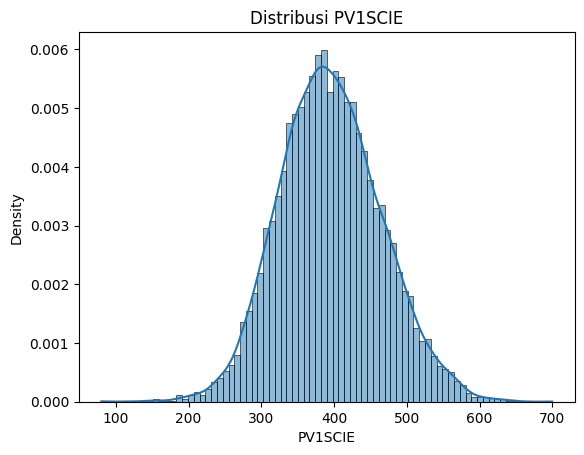

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df_clean['PV1SCIE'], kde=True, stat="density")
plt.title('Distribusi PV1SCIE')
plt.xlabel('PV1SCIE')
plt.ylabel('Density')
plt.show()


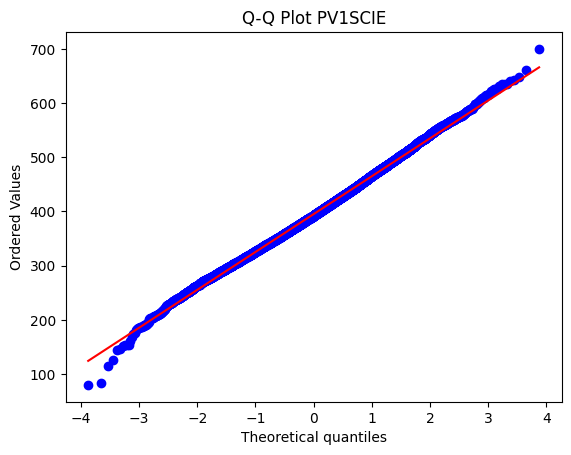

In [ ]:
import scipy.stats as stats

stats.probplot(df_clean['PV1SCIE'], dist="norm", plot=plt)
plt.title('Q-Q Plot PV1SCIE')
plt.show()

 Fungsi Regresi Weighted OLS (Untuk Satu Plausible Value)

In [ ]:
# memastikan seluruh kolom numerik, float, tidak ada NaN/object/string
for col in X_cols + ['W_FSTUWT', 'ST005Q01JA', 'ST007Q01JA', 'ESCS']:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

for i in range(1, 11):
    df_clean[f'PV{i}SCIE'] = pd.to_numeric(df_clean[f'PV{i}SCIE'], errors='coerce')
for j in range(1, 81):
    df_clean[f'W_FSTURWT{j}'] = pd.to_numeric(df_clean[f'W_FSTURWT{j}'], errors='coerce')

df_clean = df_clean.dropna(subset=X_cols + ['W_FSTUWT'] + [f'PV{i}SCIE' for i in range(1, 11)] + [f'W_FSTURWT{j}' for j in range(1, 81)])


In [ ]:
def weighted_ols(y, X, weight):
    X = sm.add_constant(X)
    model = sm.WLS(y, X, weights=weight)
    results = model.fit()
    return results

In [ ]:
X_cols = ['ESCS', 'ST005Q01JA', 'ST007Q01JA']

betas_main = []
for i in range(1, 11):
    y = df_clean[f'PV{i}SCIE']
    X = df_clean[X_cols]
    w = df_clean['W_FSTUWT']
    res = weighted_ols(y, X, w)
    betas_main.append(res.params)
betas_main = pd.DataFrame(betas_main)
beta_mean = betas_main.mean()

In [ ]:
betas_rep = []
for j in range(1, 81):
    beta_rep_j = []
    for i in range(1, 11):
        y = df_clean[f'PV{i}SCIE']
        X = df_clean[X_cols]
        w = df_clean[f'W_FSTURWT{j}']
        res = weighted_ols(y, X, w)
        beta_rep_j.append(res.params)
    beta_rep_j = pd.DataFrame(beta_rep_j)
    betas_rep.append(beta_rep_j.mean())
betas_rep = pd.DataFrame(betas_rep)

In [ ]:
se = np.sqrt(((betas_rep - beta_mean) ** 2).sum(axis=0) / 80)
lower = beta_mean - 1.96 * se
upper = beta_mean + 1.96 * se

In [ ]:
print("Koefisien rata-rata:")
for var in beta_mean.index:
    print(f"{var}: {beta_mean[var]:.3f}")

print("\nStandard Error:")
for var in se.index:
    print(f"{var}: {se[var]:.4f}")

print("\n95% Confidence Interval:")
for var in beta_mean.index:
    print(f"{var}: {lower[var]:.3f} – {upper[var]:.3f}")


Koefisien rata-rata:
const: 411.630
ESCS: 5.505
ST005Q01JA: -2.626
ST007Q01JA: -5.439

Standard Error:
const: 2.0580
ESCS: 1.3742
ST005Q01JA: 0.5207
ST007Q01JA: 0.5345

95% Confidence Interval:
const: 407.596 – 415.663
ESCS: 2.812 – 8.198
ST005Q01JA: -3.647 – -1.605
ST007Q01JA: -6.487 – -4.392


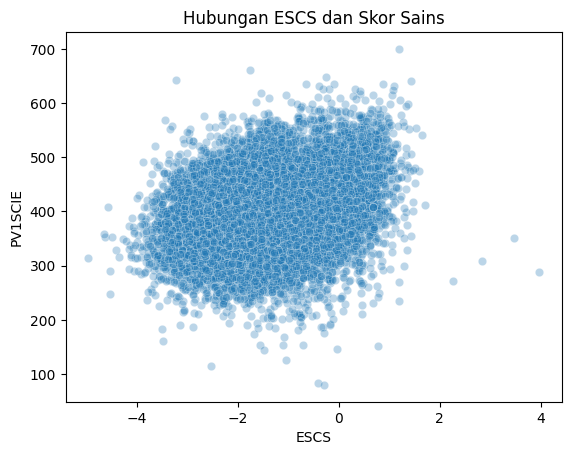

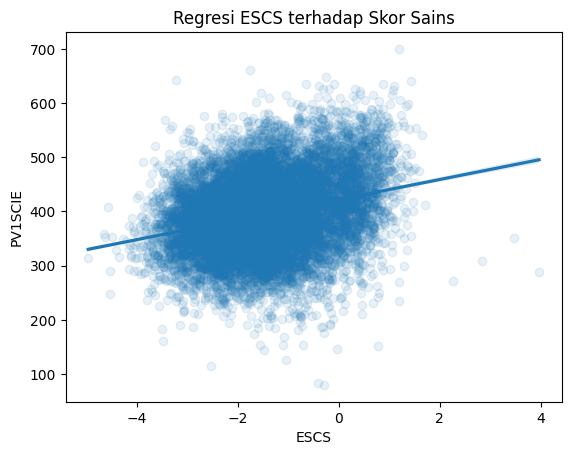

In [ ]:
# Filter untuk visualisasi (ESCS antara -5 dan 5)
df_vis = df_clean[df_clean['ESCS'].between(-5, 5)]

sns.scatterplot(x='ESCS', y='PV1SCIE', data=df_vis, alpha=0.3)
plt.title('Hubungan ESCS dan Skor Sains')
plt.xlabel('ESCS')
plt.ylabel('PV1SCIE')
plt.show()

sns.regplot(x='ESCS', y='PV1SCIE', data=df_vis, scatter_kws={'alpha':0.1})
plt.title('Regresi ESCS terhadap Skor Sains')
plt.xlabel('ESCS')
plt.ylabel('PV1SCIE')
plt.show()


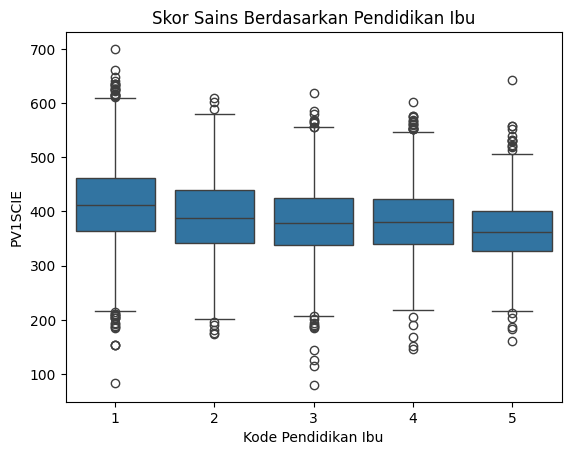

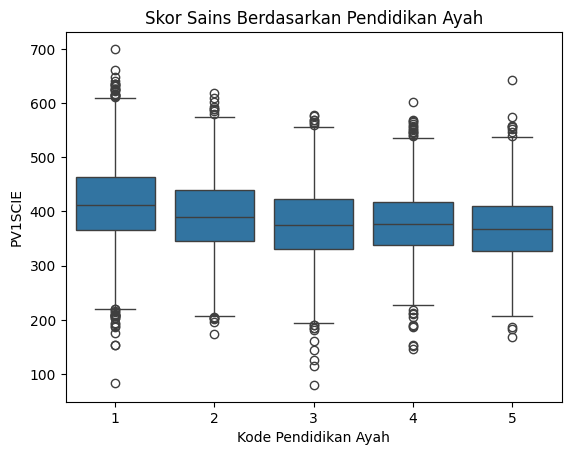

In [ ]:
# Pendidikan Ibu
sns.boxplot(x='ST005Q01JA', y='PV1SCIE', data=df_clean)
plt.title('Skor Sains Berdasarkan Pendidikan Ibu')
plt.xlabel('Kode Pendidikan Ibu')
plt.ylabel('PV1SCIE')
plt.show()

# Pendidikan Ayah
sns.boxplot(x='ST007Q01JA', y='PV1SCIE', data=df_clean)
plt.title('Skor Sains Berdasarkan Pendidikan Ayah')
plt.xlabel('Kode Pendidikan Ayah')
plt.ylabel('PV1SCIE')
plt.show()

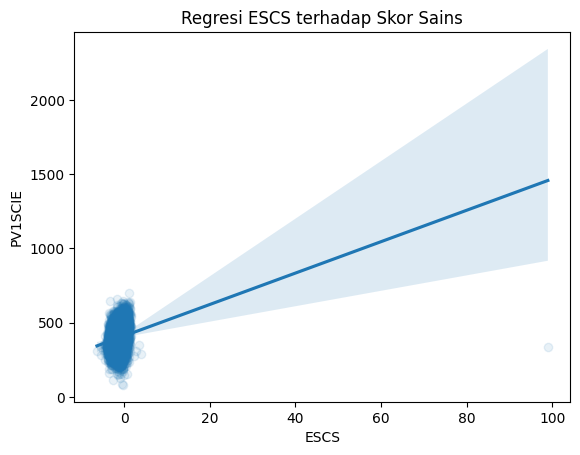

In [ ]:
# Regplot ESCS vs PV1SCIE
sns.regplot(x='ESCS', y='PV1SCIE', data=df_clean, scatter_kws={'alpha':0.1})
plt.title('Regresi ESCS terhadap Skor Sains')
plt.xlabel('ESCS')
plt.ylabel('PV1SCIE')
plt.show()